In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo dos gráficos
sns.set(style="whitegrid")
plt.style.use("ggplot")

# Caminho base
base_path = r"C:\Users\Vitor\Documents\Vitor\Desafio\archive"

# Lista de arquivos
files = {
    "customers": "olist_customers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "order_payments": "olist_order_payments_dataset.csv",
    "order_reviews": "olist_order_reviews_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "product_translation": "product_category_name_translation.csv"
}

# Dicionário para armazenar DataFrames
dfs = {}

# Carregar todos os arquivos
for key, file in files.items():
    path = os.path.join(base_path, file)
    dfs[key] = pd.read_csv(path)
    print(f"{key} carregado com {dfs[key].shape[0]} linhas e {dfs[key].shape[1]} colunas.")

# ----------------------
# Tratamentos básicos
# ----------------------

# Visualizar valores nulos por tabela
for name, df in dfs.items():
    print(f"\n{name.upper()} - Valores nulos:")
    print(df.isnull().sum())

# Limpeza da tabela orders
orders = dfs['orders'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Verificar e remover duplicatas em todas as tabelas
for name, df in dfs.items():
    dupli = df.duplicated().sum()
    if dupli > 0:
        print(f"{name}: Removendo {dupli} duplicatas.")
        dfs[name] = df.drop_duplicates()

# Normalizar nomes de categorias (juntar com tradução)
products = dfs["products"].merge(
    dfs["product_translation"],
    on="product_category_name",
    how="left"
)

# Verificar chaves primárias e estrangeiras entre tabelas
# Exemplo: join customers -> orders -> order_items -> products
df_modelo = (
    dfs["customers"]
    .merge(orders, on="customer_id", how="inner")
    .merge(dfs["order_items"], on="order_id", how="inner")
    .merge(products, on="product_id", how="inner")
    .merge(dfs["sellers"], on="seller_id", how="inner")
    .merge(dfs["order_payments"], on="order_id", how="left")
    .merge(dfs["order_reviews"], on="order_id", how="left")
)

print("\nModelo relacional criado com shape:", df_modelo.shape)

# Salvar base consolidada se quiser reutilizar
df_modelo.to_csv(os.path.join(base_path, "base_relacional_completa.csv"), index=False)



customers carregado com 99441 linhas e 5 colunas.
geolocation carregado com 1000163 linhas e 5 colunas.
order_items carregado com 112650 linhas e 7 colunas.
order_payments carregado com 103886 linhas e 5 colunas.
order_reviews carregado com 99224 linhas e 7 colunas.
orders carregado com 99441 linhas e 8 colunas.
products carregado com 32951 linhas e 9 colunas.
sellers carregado com 3095 linhas e 4 colunas.
product_translation carregado com 71 linhas e 2 colunas.

CUSTOMERS - Valores nulos:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

GEOLOCATION - Valores nulos:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

ORDER_ITEMS - Valores nulos:
order_id               0
order_item_id          0
product_id             0
seller_id              0
ship

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps

df = pd.read_csv(r"C:\Users\Vitor\Documents\Vitor\Desafio\archive\base_relacional_completa.csv")
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])


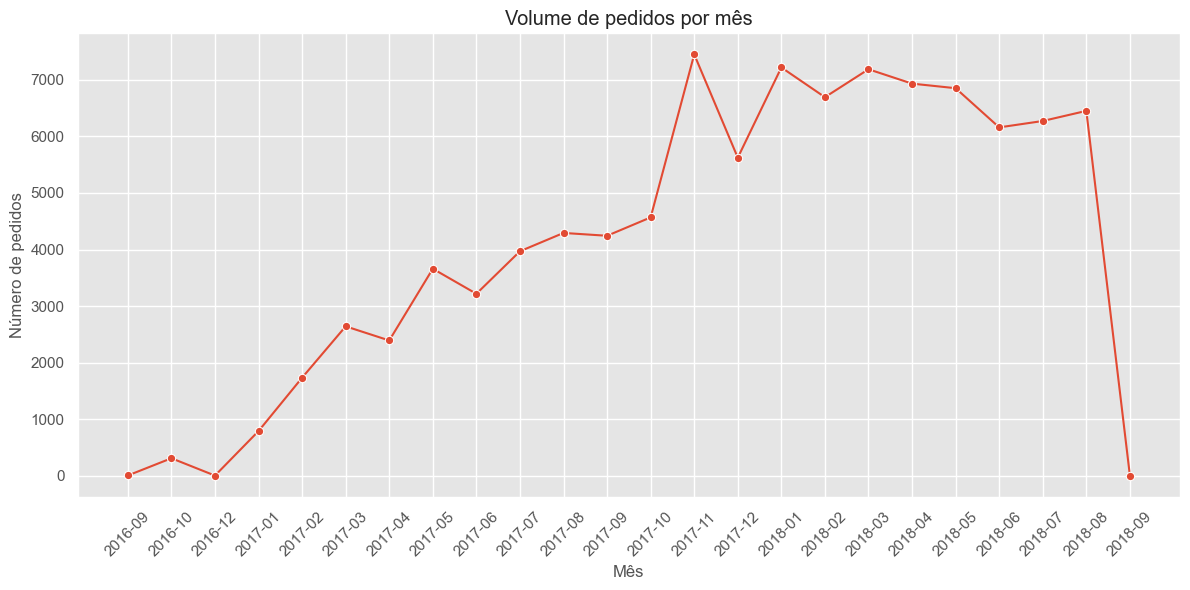

In [4]:
# Qual o volume de pedidos por mês? Existe sazonalidade nas vendas?
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')

pedidos_mensais = df.groupby('order_month')['order_id'].nunique().reset_index()
pedidos_mensais['order_month'] = pedidos_mensais['order_month'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=pedidos_mensais, x='order_month', y='order_id', marker='o')
plt.xticks(rotation=45)
plt.title('Volume de pedidos por mês')
plt.xlabel('Mês')
plt.ylabel('Número de pedidos')
plt.tight_layout()
plt.show()


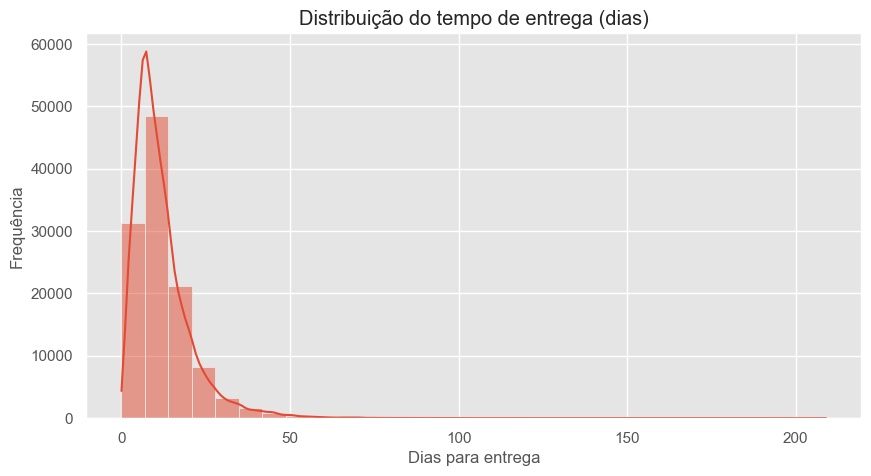

In [5]:
# Qual a distribuição do tempo de entrega dos pedidos?
df['tempo_entrega'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

plt.figure(figsize=(10, 5))
sns.histplot(df['tempo_entrega'].dropna(), bins=30, kde=True)
plt.title('Distribuição do tempo de entrega (dias)')
plt.xlabel('Dias para entrega')
plt.ylabel('Frequência')
plt.show()


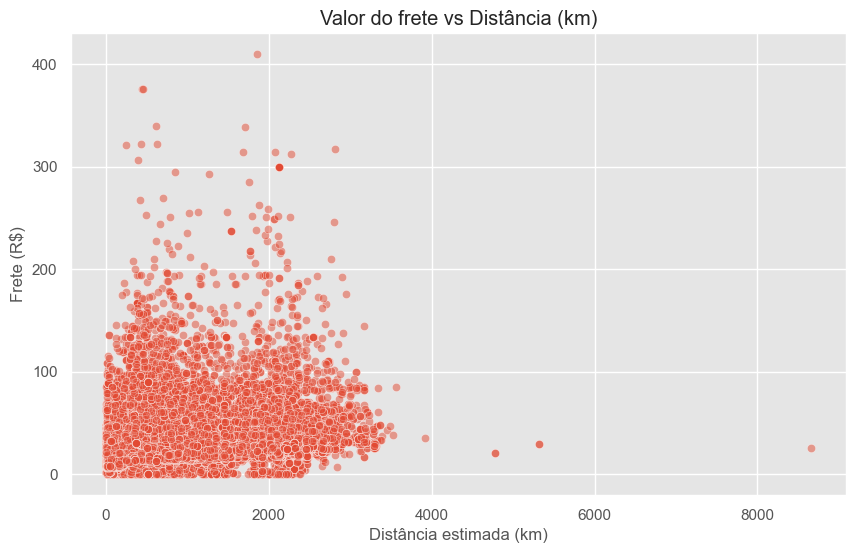

In [6]:
# Qual a relação entre o valor do frete e a distância de entrega?
from geopy.distance import geodesic

# Selecionar lat/long dos sellers e clientes
sellers = df[['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']].drop_duplicates()
customers = df[['customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']].drop_duplicates()
geolocation = pd.read_csv(r"C:\Users\Vitor\Documents\Vitor\Desafio\archive\olist_geolocation_dataset.csv")

# Agrupar por média de coordenadas por CEP
geo_grouped = geolocation.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean()

# Associar localizações
sellers = sellers.merge(geo_grouped, left_on='seller_zip_code_prefix', right_index=True)
customers = customers.merge(geo_grouped, left_on='customer_zip_code_prefix', right_index=True)

# Unir com dados principais
df_geo = df.merge(customers[['customer_id', 'geolocation_lat', 'geolocation_lng']], on='customer_id', how='left')
df_geo = df_geo.merge(sellers[['seller_id', 'geolocation_lat', 'geolocation_lng']], on='seller_id', how='left', suffixes=('_cliente', '_seller'))

# Calcular distância
def calcular_distancia(row):
    try:
        return geodesic((row['geolocation_lat_cliente'], row['geolocation_lng_cliente']),
                        (row['geolocation_lat_seller'], row['geolocation_lng_seller'])).km
    except:
        return None

df_geo['distancia_km'] = df_geo.apply(calcular_distancia, axis=1)

# Correlação entre distância e frete
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_geo, x='distancia_km', y='freight_value', alpha=0.5)
plt.title('Valor do frete vs Distância (km)')
plt.xlabel('Distância estimada (km)')
plt.ylabel('Frete (R$)')
plt.show()


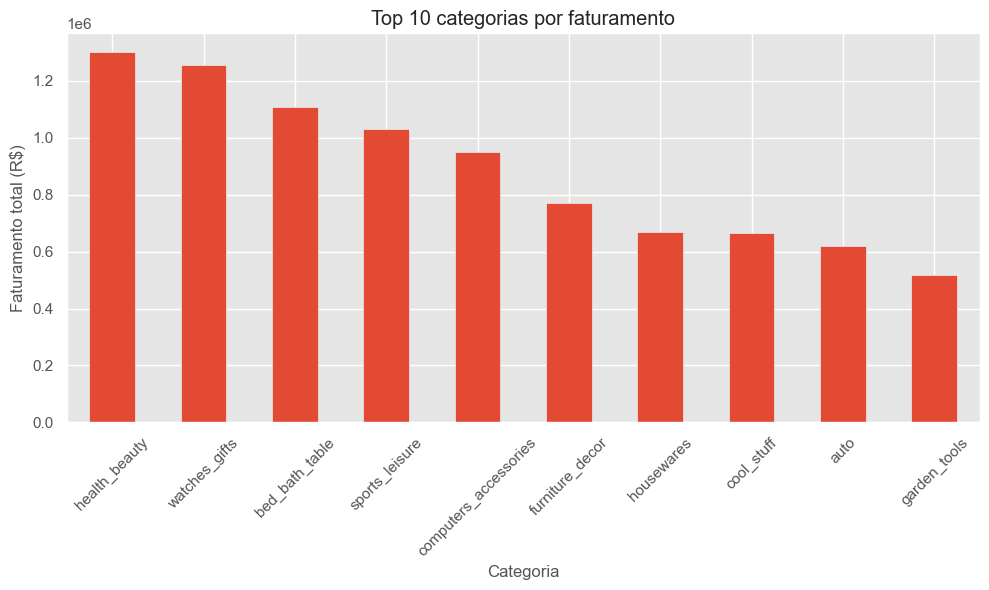

In [7]:
#  Quais são as categorias de produtos mais vendidas em termos de faturamento?
faturamento_categoria = df.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
faturamento_categoria.plot(kind='bar')
plt.title('Top 10 categorias por faturamento')
plt.xlabel('Categoria')
plt.ylabel('Faturamento total (R$)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


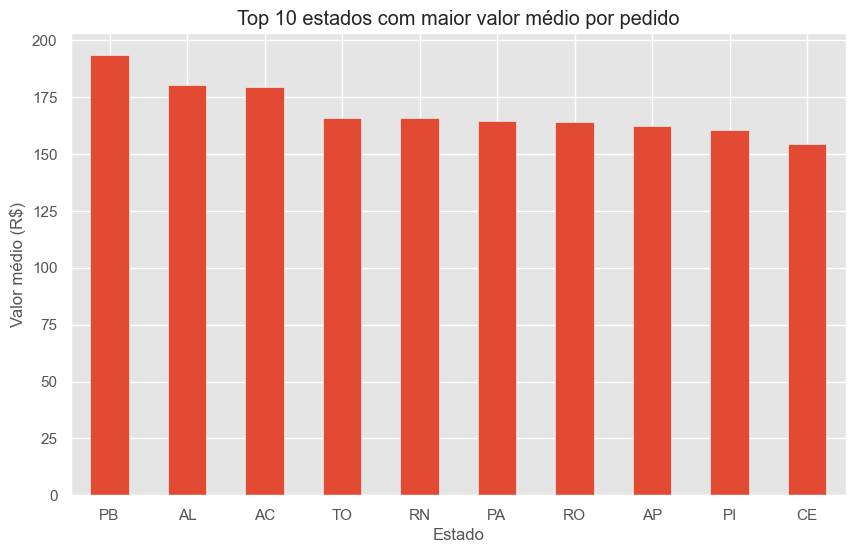

In [8]:
# Quais estados brasileiros possuem o maior valor médio de pedido?
valor_medio_estado = df.groupby('customer_state')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
valor_medio_estado.plot(kind='bar')
plt.title('Top 10 estados com maior valor médio por pedido')
plt.xlabel('Estado')
plt.ylabel('Valor médio (R$)')
plt.xticks(rotation=0)
plt.show()


Taxa de clientes recorrentes: 0.00%


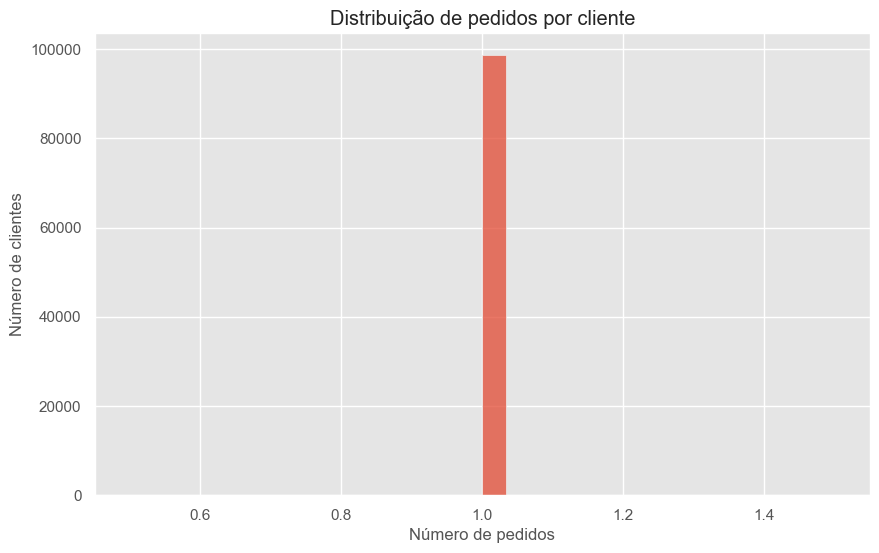

In [9]:
# Análise de Retenção (Taxa de Clientes Recorrentes)
# Número de pedidos por cliente
clientes_pedidos = df.groupby('customer_id')['order_id'].nunique()

# Identificar clientes recorrentes (fez mais de 1 pedido)
clientes_recorrentes = clientes_pedidos[clientes_pedidos > 1]

# Taxa de clientes recorrentes
taxa_recorrentes = len(clientes_recorrentes) / len(clientes_pedidos) * 100

print(f'Taxa de clientes recorrentes: {taxa_recorrentes:.2f}%')

# Visualização da distribuição de pedidos por cliente
plt.figure(figsize=(10, 6))
sns.histplot(clientes_pedidos, kde=False, bins=30)
plt.title('Distribuição de pedidos por cliente')
plt.xlabel('Número de pedidos')
plt.ylabel('Número de clientes')
plt.show()


c:\Users\Vitor\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     21277
           1       0.80      0.51      0.62      1868

    accuracy                           0.95     23145
   macro avg       0.88      0.75      0.80     23145
weighted avg       0.95      0.95      0.94     23145



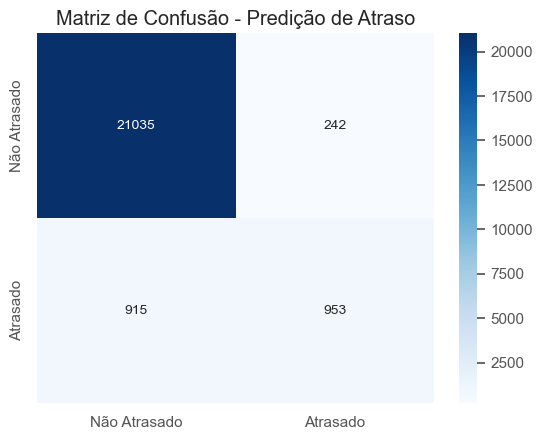

In [ ]:
# Definir se o pedido foi atrasado (1 - Atrasado, 0 - Não Atrasado)
df['atraso'] = (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']).astype(int)

# Features (não incluir datetime diretamente)
features = df[['price', 'freight_value', 'product_category_name_english', 'tempo_entrega']].copy()
features['hora_compra'] = df['order_purchase_timestamp'].dt.hour

X = pd.get_dummies(features, drop_first=True)

X = X.dropna()
y = df.loc[X.index, 'atraso'] 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Atrasado', 'Atrasado'],
            yticklabels=['Não Atrasado', 'Atrasado'])
plt.title('Matriz de Confusão - Predição de Atraso')
plt.show()


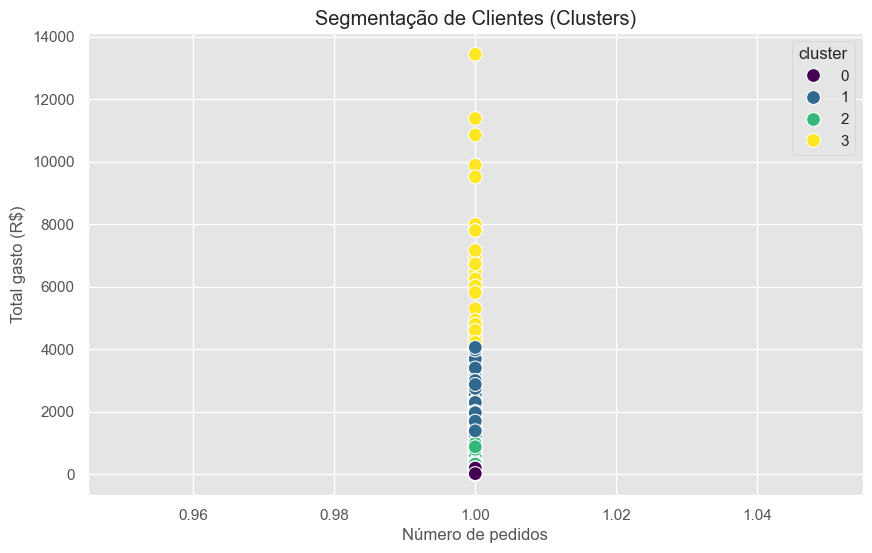

In [ ]:
# Segmentação de Clientes
from sklearn.cluster import KMeans

# Calculando total gasto por cliente e número de pedidos
clientes_clustering = df.groupby('customer_id').agg({'price': 'sum', 'order_id': 'nunique'}).reset_index()

X_cluster = clientes_clustering[['price', 'order_id']]

kmeans = KMeans(n_clusters=4, random_state=42)
clientes_clustering['cluster'] = kmeans.fit_predict(X_cluster)

# Visualizar os clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clientes_clustering, x='order_id', y='price', hue='cluster', palette='viridis', s=100)
plt.title('Segmentação de Clientes (Clusters)')
plt.xlabel('Número de pedidos')
plt.ylabel('Total gasto (R$)')
plt.show()


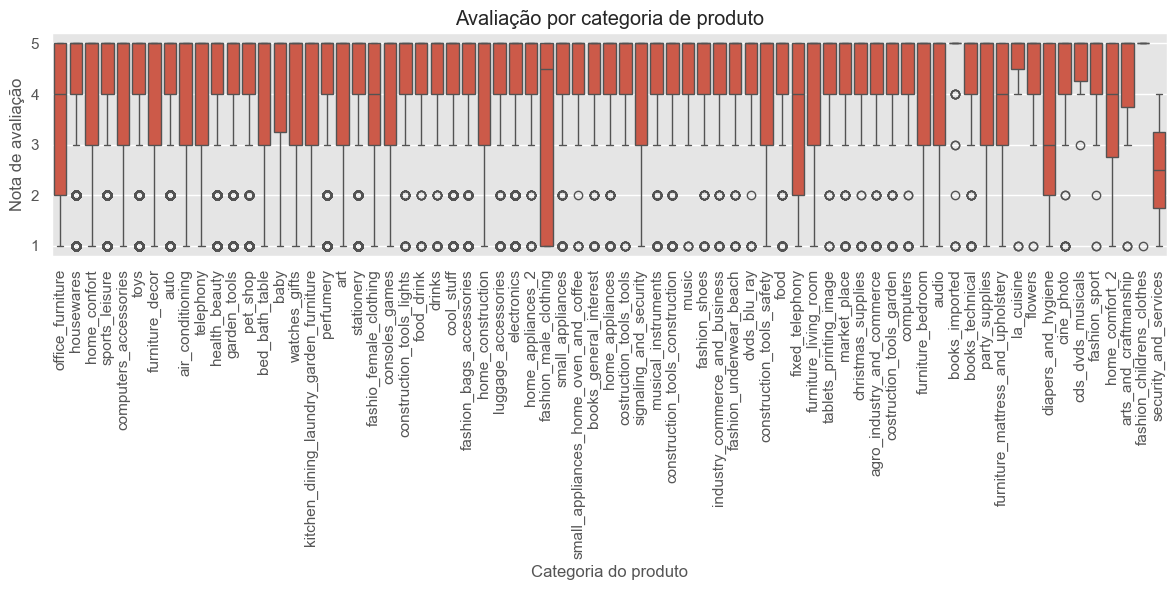

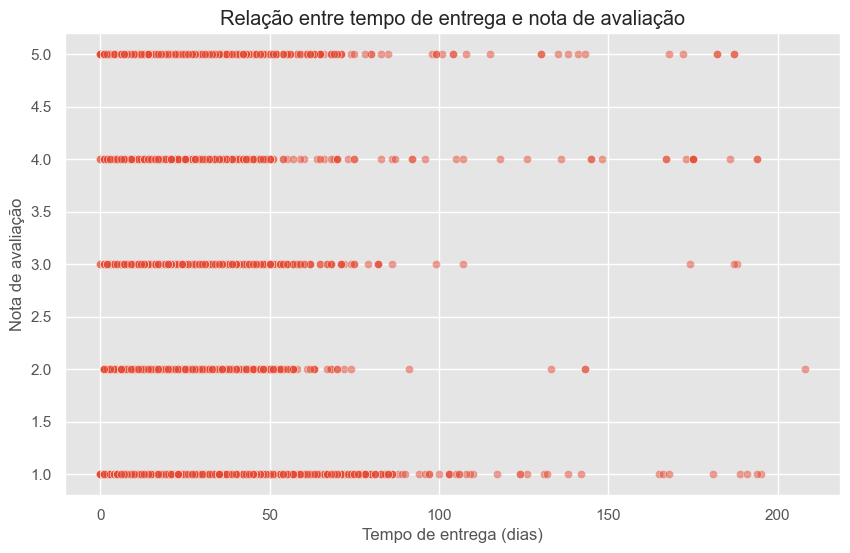

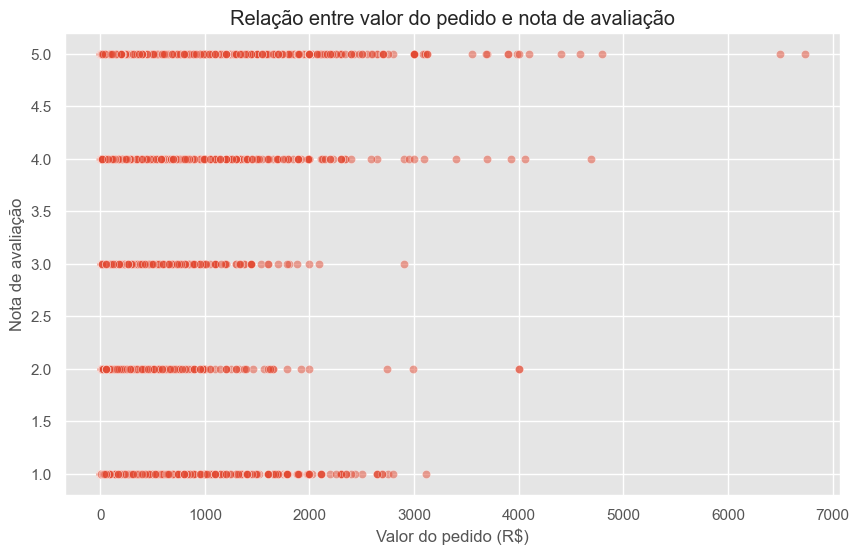

In [ ]:
# Analise de Satisfação
# Relacionando nota de avaliação com outras variáveis
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='product_category_name_english', y='review_score')
plt.xticks(rotation=90)
plt.title('Avaliação por categoria de produto')
plt.xlabel('Categoria do produto')
plt.ylabel('Nota de avaliação')
plt.tight_layout()
plt.show()

# Analisar relação entre tempo de entrega e satisfação
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tempo_entrega', y='review_score', alpha=0.5)
plt.title('Relação entre tempo de entrega e nota de avaliação')
plt.xlabel('Tempo de entrega (dias)')
plt.ylabel('Nota de avaliação')
plt.show()

# Analisar relação entre valor do pedido e avaliação
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='price', y='review_score', alpha=0.5)
plt.title('Relação entre valor do pedido e nota de avaliação')
plt.xlabel('Valor do pedido (R$)')
plt.ylabel('Nota de avaliação')
plt.show()


In [ ]:
# ETAPA 4
# Dashboard Geral: Evolução das Vendas ao Longo do Tempo
import plotly.express as px

# Agrupei por mês, estado e categoria
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)

vendas_mensais = df.groupby(['order_month', 'customer_state', 'product_category_name_english'])['price'].sum().reset_index()

# Criando o gráfico de vendas ao longo do tempo
fig = px.line(
    vendas_mensais,
    x='order_month',
    y='price',
    color='customer_state',
    line_group='product_category_name_english',
    title='Evolução das Vendas por Estado e Categoria de Produto',
    labels={
        'order_month': 'Mês',
        'price': 'Faturamento (R$)',
        'customer_state': 'Estado',
        'product_category_name_english': 'Categoria'
    },
    template='plotly_dark'
)

# Mostrar o gráfico
fig.show()



NameError: name 'df' is not defined

In [ ]:
#  Mapa de Calor: Concentração de Vendas por Região/Estado do Brasil
# Agrupando por estado e somar o valor das vendas
vendas_estado = df.groupby('customer_state')['price'].sum().reset_index()

# Criar o mapa de calor
fig = px.choropleth(vendas_estado,
                    locations='customer_state',
                    locationmode="USA-states",
                    color='price',
                    hover_name='customer_state',
                    color_continuous_scale="Viridis",
                    title='Concentração de Vendas por Estado')

# Mostrar o gráfico
fig.show()


In [ ]:
# Relação entre Avaliação do Cliente e Tempo de Entrega
# Criando gráfico de dispersão entre avaliação e tempo de entrega
fig = px.scatter(df,
                 x='tempo_entrega',
                 y='review_score',
                 color='review_score',
                 title='Relação entre Tempo de Entrega e Nota de Avaliação',
                 labels={'tempo_entrega': 'Tempo de Entrega (dias)', 'review_score': 'Nota de Avaliação'},
                 color_continuous_scale='Viridis')

# Mostrar o gráfico
fig.show()


In [ ]:
# Dashboard de Análise dos Vendedores
# Agrupar dados por vendedor

import plotly.express as px

# Agrupar dados por vendedor
vendedores = df.groupby('seller_id').agg({
    'price': 'sum',
    'review_score': 'mean',
    'tempo_entrega': 'mean'
}).reset_index()

# Remover linhas com NaN (opcional, mas importante)
vendedores = vendedores.dropna()

# Pegar top 20 vendedores por faturamento
top_vendedores = vendedores.sort_values(by='price', ascending=False).head(20)

# Gráfico 1: Faturamento
fig1 = px.bar(
    top_vendedores.sort_values(by='price'),
    x='price', y='seller_id',
    orientation='h',
    title='Top 20 Vendedores por Faturamento',
    labels={'price': 'Faturamento (R$)', 'seller_id': 'ID do Vendedor'}
)

# Gráfico 2: Satisfação média
fig2 = px.bar(
    top_vendedores.sort_values(by='review_score'),
    x='review_score', y='seller_id',
    orientation='h',
    title='Média de Satisfação por Vendedor (Top 20)',
    labels={'review_score': 'Média de Satisfação', 'seller_id': 'ID do Vendedor'}
)

# Gráfico 3: Tempo médio de entrega
fig3 = px.bar(
    top_vendedores.sort_values(by='tempo_entrega'),
    x='tempo_entrega', y='seller_id',
    orientation='h',
    title='Tempo Médio de Entrega por Vendedor (Top 20)',
    labels={'tempo_entrega': 'Tempo Médio de Entrega (dias)', 'seller_id': 'ID do Vendedor'}
)

# Mostrar os gráficos
fig1.show()
fig2.show()
fig3.show()
